# load laibraries 

In [1]:
import os
import re
import math
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import networkx as nx

from wordcloud import WordCloud
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy
nlp = spacy.load('en')
nlp.remove_pipe('parser')
nlp.remove_pipe('ner')

import gensim
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

C:\Users\user\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Read CVs

In [2]:
answers = pd.read_csv('answers.csv', encoding ='utf8')
questions = pd.read_csv('questions.csv', encoding ='utf8')
answer_scores = pd.read_csv('answer_scores.csv',encoding ='utf8')
question_scores = pd.read_csv('question_scores.csv',encoding ='utf8')
tags = pd.read_csv('tags.csv',encoding='utf8')
tag_users = pd.read_csv('tag_users.csv',encoding='utf8')
tag_questions = pd.read_csv('tag_questions.csv',encoding='utf8')

# Get Response time for questions by  the simmilar questions

In [3]:
# Spacy Tokenfilter for part-of-speech tagging
token_pos = ['NOUN', 'VERB', 'PROPN', 'ADJ', 'INTJ', 'X']

# The data export was from 1. February 2019. 
actual_date = datetime(2019, 2 ,1)

In [4]:
def nlp_preprocessing(data):
    """ Use NLP to transform the text corpus to cleaned sentences and word tokens

        param data: List with sentences, which should be processed.
        return processed_tokens: List with the cleaned and tokenized sentences
    """    
    def token_filter(token):
        """ Keep tokens who are alphapetic, in the pos (part-of-speech) list and not in stop list
            
        """    
        return not token.is_stop and token.is_alpha and token.pos_ in token_pos
    
    data = [re.compile(r'<[^>]+>').sub('', x) for x in data] #Remove HTML-tags
    processed_tokens = []
    data_pipe = nlp.pipe(data)
    for doc in data_pipe:
        filtered_tokens = [token.lemma_.lower() for token in doc if token_filter(token)]
        processed_tokens.append(filtered_tokens)
    return processed_tokens

In [5]:
questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'], infer_datetime_format=True)
answers['answers_date_added'] = pd.to_datetime(answers['answers_date_added'], infer_datetime_format=True)

In [6]:
%%time
### Questions
# Merge Question Title and Body
questions['questions_full_text'] = questions['questions_title'] +'\r\n\r\n'+ questions['questions_body']
# Count of answers
temp = answers.groupby('answers_question_id').size()
questions['questions_answers_count'] = pd.merge(questions, pd.DataFrame(temp.rename('count')), left_on='questions_id', right_index=True, how='left')['count'].fillna(0).astype(int)
# First answer for questions
temp = answers[['answers_question_id', 'answers_date_added']].groupby('answers_question_id').min()
questions['questions_first_answers'] = pd.merge(questions, pd.DataFrame(temp), left_on='questions_id', right_index=True, how='left')['answers_date_added']
# Last answer for questions
temp = answers[['answers_question_id', 'answers_date_added']].groupby('answers_question_id').max()
questions['questions_last_answers'] = pd.merge(questions, pd.DataFrame(temp), left_on='questions_id', right_index=True, how='left')['answers_date_added']
# Hearts Score
temp = pd.merge(questions, question_scores, left_on='questions_id', right_on='id', how='left')
questions['questions_hearts'] = temp['score'].fillna(0).astype(int)
# Questions Tags list
temp = pd.merge(questions, tag_questions, left_on='questions_id', right_on='tag_questions_question_id', how='inner')
temp = pd.merge(temp, tags, left_on='tag_questions_tag_id', right_on='tags_tag_id', how='inner')
temp = temp.groupby('questions_id')['tags_tag_name'].apply(list).rename('questions_tags')
questions['questions_tags'] = pd.merge(questions, temp.to_frame(), left_on='questions_id', right_index=True, how='left')['questions_tags']
# Get NLP Tokens
questions['nlp_tokens'] = nlp_preprocessing(questions['questions_full_text'])

Wall time: 2min 29s


In [7]:
### Answers
# Days required to answer the question
temp = pd.merge(questions, answers, left_on='questions_id', right_on='answers_question_id')
answers['time_delta_answer'] = (temp['answers_date_added'] - temp['questions_date_added'])
# Ranking for answers time
answers['answers_time_rank'] = answers.groupby('answers_question_id')['time_delta_answer'].rank(method='min').astype(int)
# Hearts Score
temp = pd.merge(answers, answer_scores, left_on='answers_id', right_on='id', how='left')
answers['answers_hearts'] = temp['score'].fillna(0).astype(int)

In [8]:
# questions['queation_answer_period']=[x-y for x in answers['answers_date_added'] for y in questions['questions_date_added']]
# Days required to answer the question
temp = pd.merge(questions, answers, left_on='questions_id', right_on='answers_question_id')
questions['queation_answer_period'] = (temp['answers_date_added'] - temp['questions_date_added'])

In [9]:
def get_similar_question_period(questions_text, questions=questions, threshold=0.5, top=8, answered=True):
    """ Calculates the similarity to the existing questions and returns the most similar ones.
        
        :param questions_text: List with text of new questions to get the similiarities
        :param threshold: Threshold to filter out all questions with similarity below the value (default: 0.01)
        :param top: Top N similar questions (default: 5)
        :param answered: Consider only answered questions (default: True)
        :return result: DataFrame with the top similar questions
    """ 
    nlp_corpus = [' '.join(x) for x in questions['nlp_tokens']]
    nlp_text = [' '.join(x) for x in nlp_preprocessing(questions_text)]
    vectorizer = TfidfVectorizer()
    vectorizer.fit(nlp_corpus)
    corpus_tfidf = vectorizer.transform(nlp_corpus)
    
    text_tfidf = vectorizer.transform(nlp_text)
    sim = cosine_similarity(corpus_tfidf, text_tfidf)
    result = pd.DataFrame({'questions_id':np.tile(questions['questions_id'], sim.shape[1]),
                           'similarity':sim.reshape(-1,),
                          'title':np.tile(questions['questions_title'], sim.shape[1]),
                          'body':np.tile(questions['questions_body'], sim.shape[1]),
                           'questions_tags':np.tile(questions['questions_tags'], sim.shape[1]),
                          'queation_answer_period':np.tile(questions['queation_answer_period'], sim.shape[1]),
                           #'queation_answer_period':np.tile(questions['queation_answer_period'], sim.shape[1]),
                           },
                         index=np.tile(questions.index, sim.shape[1]))
    if answered:
        result = result[questions['questions_answers_count'] > 0]
    result = result[result['similarity'] >= threshold].sort_values(['queation_answer_period'],ascending=[True]).head(top)
    return result

In [161]:
query_text = ['I will finish my college next year and would like to start a career as a Data Scientist. \n\n'\
            +'What is the best way to become a good Data Scientist? #data-science']
questions_corpus = questions[questions['questions_date_added'] > '2017-01-01']
get_similar_question_period(query_text, questions=questions_corpus).T

,1237,3519,23840,6106,641,22846,21111
questions_id,be8468b58fd04edc92a2c3d0498ae2fe,a3f54457202e4ec595cb77ce85f30503,04e65383a3254babb245af2cdeb8648c,e6e7205bcce14d52b8703530521d899b,ed2c4ae96c24444cba1905a4c258eb91,cdb039631662456792ecff182e0124fc,9909cdbebb5c4b9ea585f405e28bacae
similarity,0.603305,0.56691,0.687954,0.584692,0.720555,0.508841,0.617636
title,Which program is best to start learning coding?,What collage do you need to be a coder?,How long do you need to go to collage for? Wha...,What is hard about coding and if I succeed wil...,how do you learn coding also what is the time ...,Do you have to know how to code to create apps?,"If you know coding, what high paying jobs are ..."
body,I want to learn to code. Should I start with p...,I love coding. #technology #tech #coding,I love to code. #technology #tech #coding #code,Is coding fun because we and my friend want to...,#coding \r\n,I took a coding class in high school but don't...,I will be doing a coding internship over the s...
questions_tags,"[computer-science, coding]","[tech, technology, coding]","[tech, technology, coding, code]",[coding],[coding],"[coding, mobile-applications, app-development]","[tech, computers, coding]"
queation_answer_period,0 days 11:06:54,0 days 20:58:35,6 days 13:56:48,23 days 15:57:23,36 days 16:01:35,244 days 18:26:24,769 days 12:36:33


# clssification questions on different periods

In [108]:
df_Q=questions.copy()

In [109]:
df_Q.head()

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_full_text,questions_answers_count,questions_first_answers,questions_last_answers,questions_hearts,questions_tags,nlp_tokens,queation_answer_period
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26,Teacher career question,What is a maths teacher? what is a ma...,Teacher career question\r\n\r\nWhat is a...,1,2016-04-29 19:40:14,2016-04-29 19:40:14,1,"[lecture, college, professor]","[teacher, career, question, maths, teacher, ma...",3 days 08:25:48
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25,I want to become an army officer. What can I d...,I am Priyanka from Bangalore . Now am in 10th ...,I want to become an army officer. What can I d...,2,2018-05-01 14:19:08,2018-05-02 02:41:02,5,"[military, army]","[want, army, officer, army, officer, priyanka,...",710 days 21:30:43
2,4ec31632938a40b98909416bdd0decff,f2c179a563024ccc927399ce529094b5,2017-02-08 19:13:38,Will going abroad for your first job increase ...,I'm planning on going abroad for my first job....,Will going abroad for your first job increase ...,1,2017-05-10 19:00:47,2017-05-10 19:00:47,2,"[overseas, working-abroad]","[go, job, increase, chance, job, plan, go, job...",711 days 09:52:37
3,2f6a9a99d9b24e5baa50d40d0ba50a75,2c30ffba444e40eabb4583b55233a5a4,2017-09-01 14:05:32,To become a specialist in business management...,i hear business management is a hard way to ge...,To become a specialist in business management...,2,2017-10-12 16:01:44,2017-10-13 22:07:33,2,"[networking, business]","[specialist, business, management, network, he...",90 days 23:47:09
4,5af8880460c141dbb02971a1a8369529,aa9eb1a2ab184ebbb00dc01ab663428a,2017-09-01 02:36:54,Are there any scholarships out there for stude...,I'm trying to find scholarships for first year...,Are there any scholarships out there for stude...,2,2017-09-29 18:50:11,2018-06-08 02:39:02,2,"[college, scholarships, highschoolsenior, firs...","[scholarship, student, generation, live, ga, t...",42 days 08:02:01


In [110]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23931 entries, 0 to 23930
Data columns (total 13 columns):
questions_id               23931 non-null object
questions_author_id        23931 non-null object
questions_date_added       23931 non-null datetime64[ns]
questions_title            23931 non-null object
questions_body             23931 non-null object
questions_full_text        23931 non-null object
questions_answers_count    23931 non-null int32
questions_first_answers    23110 non-null datetime64[ns]
questions_last_answers     23110 non-null datetime64[ns]
questions_hearts           23931 non-null int32
questions_tags             23288 non-null object
nlp_tokens                 23931 non-null object
queation_answer_period     23931 non-null timedelta64[ns]
dtypes: datetime64[ns](3), int32(2), object(7), timedelta64[ns](1)
memory usage: 2.2+ MB


In [111]:
# creat periods list  :
periods=df_Q['queation_answer_period'].apply(lambda x: str(x).split()[0]).values

In [112]:
# replace numbers with classes :
per = []
for x in periods:
    if int(x) <= 1:
        per.append('VS')
#         print('from p1 befor replacing',x)
#         periods=periods.apply(lambda x: x.replace(x,'VS'))
#         print('from p1',periods)
    elif int(x) <= 4 and int(x) != 1 :#or x <= datetime.timedelta(days=3) :
        per.append('S')
#         print('from p2 befor replacing',x)
#         periods= periods.replace(x,'S').astype(str)
#         print('from p2 after',periods2)
    elif int(x) <= 8 and int(x) != 4:
        per.append('M')
#         #or x <= datetime.timedelta(days=5) or x <= datetime.timedelta(days=6) or x <= datetime.timedelta(days=7):
#         print('from p3 befor replacing',x)
#         periods=periods.replace(x,'M').astype(str)
#         print('from p3',periods3)
    elif int(x) <= 15 and int(x) != 8:
        per.append('L')
#         # or x == datetime.timedelta(days=9) or x == datetime.timedelta(days=10) or x == datetime.timedelta(days=11) or x == datetime.timedelta(days=12) or x == datetime.timedelta(days=13)  or x == datetime.timedelta(days=14):
#         print('from p4 befor replacing',x)
#         periods=periods.replace(x,'L').astype(str)
#         print('from p4',periods4)
    else:
        per.append('VL')
#         print('from p5 befor replacing',x)
#         periods=periods.replace(x,'VL').astype(str)
#         print('from p5',periods5)
        


In [113]:
# change the values  
df_Q['periods'] = per

In [114]:
df_Q.head()

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_full_text,questions_answers_count,questions_first_answers,questions_last_answers,questions_hearts,questions_tags,nlp_tokens,queation_answer_period,periods
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26,Teacher career question,What is a maths teacher? what is a ma...,Teacher career question\r\n\r\nWhat is a...,1,2016-04-29 19:40:14,2016-04-29 19:40:14,1,"[lecture, college, professor]","[teacher, career, question, maths, teacher, ma...",3 days 08:25:48,S
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25,I want to become an army officer. What can I d...,I am Priyanka from Bangalore . Now am in 10th ...,I want to become an army officer. What can I d...,2,2018-05-01 14:19:08,2018-05-02 02:41:02,5,"[military, army]","[want, army, officer, army, officer, priyanka,...",710 days 21:30:43,VL
2,4ec31632938a40b98909416bdd0decff,f2c179a563024ccc927399ce529094b5,2017-02-08 19:13:38,Will going abroad for your first job increase ...,I'm planning on going abroad for my first job....,Will going abroad for your first job increase ...,1,2017-05-10 19:00:47,2017-05-10 19:00:47,2,"[overseas, working-abroad]","[go, job, increase, chance, job, plan, go, job...",711 days 09:52:37,VL
3,2f6a9a99d9b24e5baa50d40d0ba50a75,2c30ffba444e40eabb4583b55233a5a4,2017-09-01 14:05:32,To become a specialist in business management...,i hear business management is a hard way to ge...,To become a specialist in business management...,2,2017-10-12 16:01:44,2017-10-13 22:07:33,2,"[networking, business]","[specialist, business, management, network, he...",90 days 23:47:09,VL
4,5af8880460c141dbb02971a1a8369529,aa9eb1a2ab184ebbb00dc01ab663428a,2017-09-01 02:36:54,Are there any scholarships out there for stude...,I'm trying to find scholarships for first year...,Are there any scholarships out there for stude...,2,2017-09-29 18:50:11,2018-06-08 02:39:02,2,"[college, scholarships, highschoolsenior, firs...","[scholarship, student, generation, live, ga, t...",42 days 08:02:01,VL


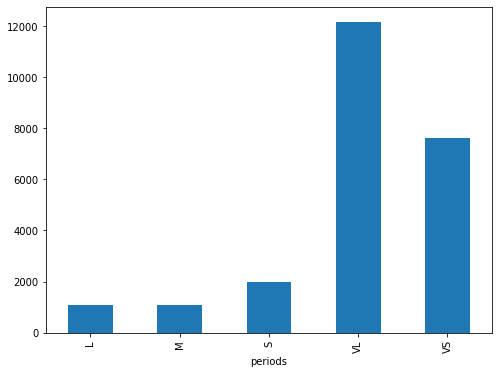

In [115]:
# we can see her there is bies !
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_Q.groupby('periods').questions_id.count().plot.bar(ylim=0)
plt.show()

In [116]:
df_Q.groupby('periods').questions_id.count()

periods
L      1091
M      1091
S      1977
VL    12152
VS     7620
Name: questions_id, dtype: int64

In [117]:
# to fix bies 
import numpy as np

def balanced_subsample(y, size=None):

    subsample = []

    if size is None:
        n_smp = y.value_counts().min()
    else:
        n_smp = int(size / len(y.value_counts().index))

    for label in y.value_counts().index:
        samples = y[y == label].index.values
        index_range = range(samples.shape[0])
        indexes = np.random.choice(index_range, size=n_smp, replace=False)
        subsample += samples[indexes].tolist()

    return subsample

In [128]:
x=balanced_subsample(df_Q['periods'])

In [132]:
np.shape(x)

(5455,)

In [138]:
df_Q=pd.DataFrame(index=x,data=df_Q)

In [141]:
df_Q.shape

(5455, 14)

In [144]:
# now we can see all values have same size :)
df_Q.groupby('periods').questions_id.count()

periods
L     1091
M     1091
S     1091
VL    1091
VS    1091
Name: questions_id, dtype: int64

-  remove missing values
-  add a column encoding the periods as an integer because categorical variables are often better represented by integers than  strings.
- create a couple of dictionaries for future use.

In [142]:
from io import StringIO
col = ['periods', 'questions_title']
df = df_Q[col]
df = df[pd.notnull(df['questions_title'])]
df.columns = ['periods', 'questions_title']
df['period_id'] = df['periods'].factorize()[0]
period_id_df = df[['periods', 'period_id']].drop_duplicates().sort_values('period_id')
period_to_id = dict(period_id_df.values)
id_to_period = dict(period_id_df[['period_id', 'periods']].values)
df.head()

,periods,questions_title,period_id
18718,VL,I am thinking about double majoring in nonprof...,0
18045,VL,How do you find the best solutions for balanci...,0
17266,VL,"When is it a good time to ""leave the nest""?",0
11265,VL,What the difference between medicinal chemistr...,0
8422,VL,How can one build her/his network?,0


After cleaning up, this is the first five rows of the data

- Text Representation : 
  1. converted to a more manageable representation.
  2. we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. 


In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.questions_title).toarray()
labels = df.period_id
features.shape

(5455, 1323)

Now, each of 4569 consumer complaint narratives is represented by 12633 features, 
representing the tf-idf score for different unigrams and bigrams.

- We can use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the products:

In [147]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for periods, period_id in sorted(period_to_id.items()):
    features_chi2 = chi2(features, labels == period_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(period))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'VS':
  . Most correlated unigrams:
. scholarship
. resume
  . Most correlated bigrams:
. career choices
. school years
# 'VS':
  . Most correlated unigrams:
. easiest
. investigator
  . Most correlated bigrams:
. major computer
. psychology degree
# 'VS':
  . Most correlated unigrams:
. journalist
. local
  . Most correlated bigrams:
. major study
. environmental science
# 'VS':
  . Most correlated unigrams:
. energy
. qualifications
  . Most correlated bigrams:
. typical work
. best schools
# 'VS':
  . Most correlated unigrams:
. freshman
. maths
  . Most correlated bigrams:
. freshman year
. college job


# Multi-Class Classifier: Features and Design
- To train supervised classifiers, we first transformed the “questions_title” into a vector of numbers. We explored vector representations such as TF-IDF weighted vectors.
- After having this vector representations of the text we can train supervised classifiers to train unseen “questions_title” and predict the “periods” on which they fall.



Naive Bayes Classifier: the one most suitable for word counts is the multinomial variant:

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['questions_title'], df['periods'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

After fitting the training set, let’s make some predictions.

In [157]:
print(clf.predict(count_vect.transform(['what is a dead code?'])))

['VS']


# Model Selection

We are now ready to experiment with different machine learning models, evaluate their accuracy and find the source of any potential issues.
We will benchmark the following four models:
- Logistic Regression
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver 

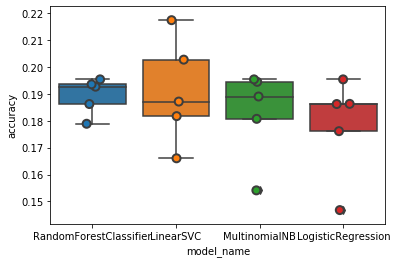

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [151]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.191026
LogisticRegression        0.178178
MultinomialNB             0.182762
RandomForestClassifier    0.189365
Name: accuracy, dtype: float64

LinearSVC and Logistic Regression perform better than the other two classifiers, with LinearSVC having a slight advantage with a median accuracy of around 19%.

# Model Evaluation


Continue with our best model (LinearSVC), we are going to look at the confusion matrix, and show the discrepancies between predicted and actual labels.

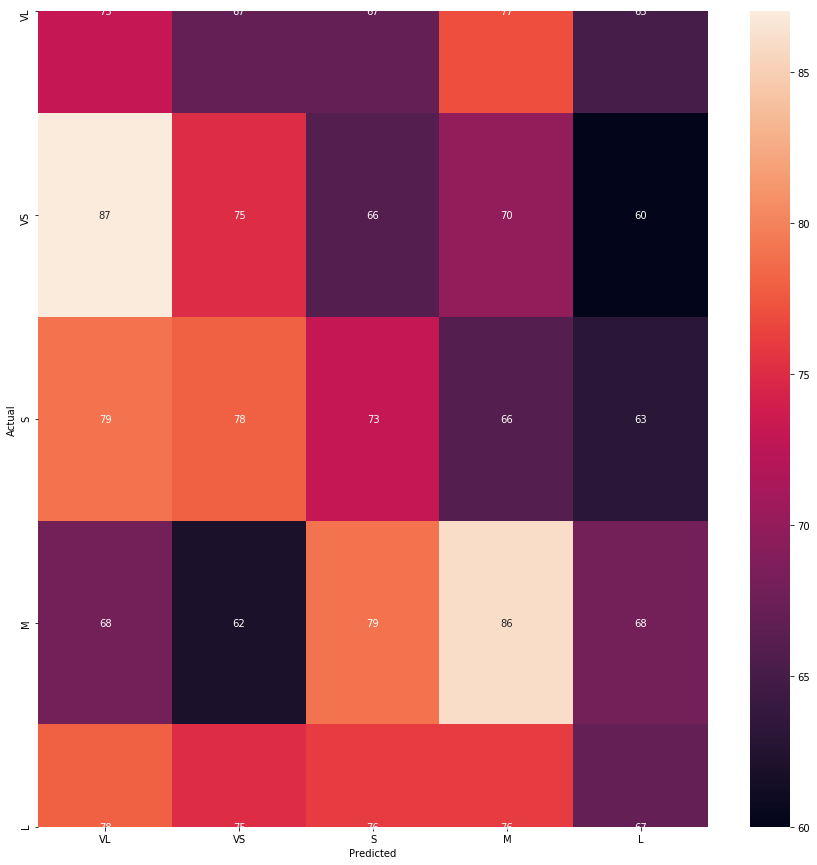

In [152]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=period_id_df.periods.values, yticklabels=period_id_df.periods.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


there are a number of misclassifications, and it might be interesting to see what those are caused by:

In [153]:
from IPython.display import display
for predicted in period_id_df.period_id:
    for actual in period_id_df.period_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_period[actual], id_to_period[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['periods', 'questions_title']])
        print('')


'VS' predicted as 'VL' : 87 examples.


,periods,questions_title
6605,VS,How did you go about becoming an accountant?
5637,VS,How hard is it to become an owner of a franchise?
6093,VS,How do I go about finding scholarships that I ...
22356,VS,Is becoming a CPA worth it?
22269,VS,What is the CPA like?
2144,VS,What are the differences between the work a py...
23222,VS,How do you have embellishment ideas for fashion?
16949,VS,What is the best way to help decide what type ...
21077,VS,What are some resources you wish you had known...
5738,VS,"I am pursuing a major in psychology this fall,..."



'S' predicted as 'VL' : 79 examples.


,periods,questions_title
8665,S,What are good majors to take to become an elem...
4432,S,How many years of school will I have to go thr...
3705,S,How do you deal with the emotional impact of w...
15770,S,What is a good school to continue my bachelors...
7780,S,What to look forward to as an Aerospace Engineer?
5560,S,Passion or money?
776,S,Is it smart to major and minor or just focus o...
20233,S,"I'm thinking of applying for an internship, bu..."
19155,S,How much do lawyer get payd
13145,S,Do you have a lot of free time at work being a...



'M' predicted as 'VL' : 68 examples.


,periods,questions_title
23756,M,What are some important aspects that a future ...
2220,M,How would I start a boutique for selling my ow...
8227,M,Where is a good place to study the skills to b...
9504,M,Will I be able to keep busy and learn more in ...
8084,M,Is summer school considered bad when applying ...
21698,M,What is the best way to go about scheduling my...
20294,M,"On average, how expensive is pursuing a PhD?"
4565,M,After a 5 year architecture undergrad program ...
16529,M,Why is it hard to find an affordable college o...
3334,M,Should I apply for a internship or get a paid ...



'L' predicted as 'VL' : 78 examples.


,periods,questions_title
21035,L,How would I be able to incorporate my minor in...
18565,L,Do school counselors' role vary depending on t...
14952,L,What psychology careers have a consistent sche...
19670,L,What are some career choices for a Psychology/...
7372,L,What are some of the best ways to get scholars...
15434,L,Is being a lawyer satisfactory?
1122,L,What type of things do aerospace engineers do?
23327,L,I have opted for home science as an optional s...
9225,L,Inexpensive or Free Textbooks
19863,L,Should I go to collage? What are some advantag...



'VL' predicted as 'VS' : 67 examples.


,periods,questions_title
9532,VL,How do you get a good paying job
18238,VL,Is it possible that I could spend a day in a p...
574,VL,What if I don't want to go to college. Are the...
21546,VL,What are some good universities for a cello pe...
21350,VL,What can you do with you Psychology BA degree?
17613,VL,How Do I Sell Books in More Than One Genre?
22549,VL,Do you have suggestion to international student?
2204,VL,#MaterialHandling
15554,VL,How do you start paying for college?
6586,VL,What do you need to major in to become a Forei...




'S' predicted as 'VS' : 78 examples.


,periods,questions_title
19043,S,What are some good study tips for a high schoo...
19447,S,How does one develop and execute their own Pri...
7346,S,What advice would you give to a student moving...
6454,S,I am interested in cars but I do not want to d...
17773,S,How do I build a relationship with a professio...
2648,S,How do I get colleges to notice me?
15950,S,What is the best major to pursue for a future ...
8894,S,What does it truly mean to do 'research' in to...
9999,S,As an adult what are some good money saving st...
8086,S,How will I know when I am truly ready to go to...



'M' predicted as 'VS' : 62 examples.


,periods,questions_title
23076,M,What classes should i take in high school if i...
1970,M,Is it better to choose a career path that is s...
2908,M,which field should I go after 10+2 as my maths...
462,M,What does a software engineer do on a day to d...
6763,M,I am moving to Michigan soon with my husband w...
23338,M,What are the pros and cons of joining a career...
4196,M,What are the pros and cons of going to graduat...
22366,M,Is the acting field the hardest?
4058,M,How to manage your time in school?
16029,M,How do aviation majors manage to pay for all t...



'L' predicted as 'VS' : 75 examples.


,periods,questions_title
17652,L,How can I access information about casting cal...
22212,L,What if you have a question?
12016,L,Is there shadowing for pharmacists?
13576,L,How can I figure out what career path is best ...
17403,L,How can I get interested in studying and impro...
12437,L,Is music production something I should go to c...
12216,L,What are some study tips for biology?
2864,L,What is college? Why is college so important?
699,L,When do you start paying for college?
5027,L,What is the best way to stay up to date on adv...



'VL' predicted as 'S' : 67 examples.


,periods,questions_title
8026,VL,What are some ways I can make my college appli...
3792,VL,Should I look into going to my local community...
19026,VL,what work environment do medical examiners wor...
22445,VL,Is it possible to study abroad during the summer?
410,VL,Is it a good idea to major in Biology for pre-...
17061,VL,What kind of jobs can be landed with a Compute...
18315,VL,How much does a major in the air force make?
14864,VL,how to become a video game designer
14050,VL,i want to join a hotel management course?
1132,VL,How whats one major thing to worry about going...



'VS' predicted as 'S' : 66 examples.


,periods,questions_title
10542,VS,Best markets to break into?
18186,VS,How does somebody who has not played a particu...
23262,VS,How many years do I need to get a masters degr...
23077,VS,"Working a job can be stressful, what do you th..."
14923,VS,Is it better to get my Nurse practitioner or p...
2546,VS,Which colleges/universities should I apply to?
17698,VS,How will an undergraduate business degree in f...
6640,VS,How likely am I to get a job in the accounting...
22257,VS,"As a future mental health nurse practitioner, ..."
6964,VS,"What is the Occupational Therapist exam about,..."




'M' predicted as 'S' : 79 examples.


,periods,questions_title
21070,M,What different types of accounting fields are ...
1912,M,what should I major in for pre-med?
15580,M,What motivated you to pursue a career in law?
13215,M,Is it a bad thing to switch your major?
2068,M,What would be a good job to get with my creden...
968,M,what are different types of engineering?
9030,M,What is a good first programming language?
14071,M,What are some entry level jobs in the airline ...
8356,M,What is the easiest way to earn a scholarship?
9484,M,What kind of job can I apply for with a Music ...



'L' predicted as 'S' : 76 examples.


,periods,questions_title
18510,L,How to become a good business?
8481,L,Are there any available programs/events/resour...
14229,L,What different career paths can an internation...
7972,L,My Master's degree in Psychology from India is...
23593,L,Can you ask an employer for the adverage salary?
18632,L,Everyday life
15648,L,Will you get any alone time if you dorm on cam...
2407,L,What's the difference between a counselor and ...
5750,L,How can I become a video game designer?
21337,L,How do hiring managers in libraries view onlin...



'VL' predicted as 'M' : 77 examples.


,periods,questions_title
17051,VL,How many internships is too many?
11409,VL,who own a business and want to hire me ?
22872,VL,What should I do to prepare for medical school?
16422,VL,What jobs are available to Theoretical Astroph...
3886,VL,what collage do i need to work in a bank?
3125,VL,Which do you find better when it comes to the ...
704,VL,What is the best college to attend for an aspi...
22189,VL,How can you make a living off of being a write...
10354,VL,What does an OBGYN do while in residency?
20498,VL,How can I afford college if I don't have anyon...



'VS' predicted as 'M' : 70 examples.


,periods,questions_title
18539,VS,Why is it a bad idea to triple major if I know...
12726,VS,Gen Eds before 4-year?
5678,VS,What are good scholarships for freshmen?
19077,VS,Is most of your day spent working when being a...
12556,VS,What courses do I exactly need to complete my ...
21499,VS,Colleges for Assistant Nurses?
3796,VS,Is there a career combining videography and mi...
21518,VS,How long does it take to pay off your whole co...
17394,VS,What are some of the most important things and...
11217,VS,What specific skills do I need to be a communi...



'S' predicted as 'M' : 66 examples.


,periods,questions_title
9676,S,What college is best fitted for me if i am a m...
10387,S,Aeronatical Engineering career question
14800,S,where can I get the best training for martial ...
17122,S,If I choose to be a photographer and later on ...
16544,S,What is the best way to find the perfect colle...
17483,S,What did you have to do to get in to this job?
17190,S,Is makeup artistry a competitive career?
3965,S,What kind of classes should in college if I wa...
11773,S,What's the most complicated part of being a ph...
5831,S,What do you surgeons actually do on a regular ...




'L' predicted as 'M' : 76 examples.


,periods,questions_title
5751,L,what benifits does this company offer?
8856,L,Is WSU widely recognized in the engineering co...
3308,L,jobs freshmen year of college?
23867,L,Why is Obstetrician/Gynecologist a combined pr...
18853,L,Do you have to go to college to play in the nfl
9609,L,what is the best for me?
14918,L,Is it best to go to law school once you comple...
21932,L,Due to the under-representation of women in en...
14758,L,What is a typical day like working as a police...
15420,L,How can I learn Korean by myself?



'VL' predicted as 'L' : 65 examples.


,periods,questions_title
18794,VL,Does the college you go to really matter when ...
13074,VL,"As a Pathologist, is more of your work compute..."
3602,VL,What is the hardest thing about moving in to c...
11674,VL,Hello! I am an undergraduate student majoring ...
3650,VL,How much money does a computer specialist make?
22025,VL,What are my (and anyone's) chances of getting ...
273,VL,"Is it ever too late to change careers? If so, ..."
19105,VL,What is the preferred major a student should t...
23098,VL,"I want to be an English major, but I'm wonderi..."
19080,VL,Would any college in Texas Lusiana Oklahoma or...



'VS' predicted as 'L' : 60 examples.


,periods,questions_title
1934,VS,What to expect in an education program at coll...
4932,VS,Ive always been interested in the Law enforcem...
22061,VS,What is the difference between a Bachelor's i...
14092,VS,Which colleges/universities have programs in m...
14702,VS,What kind of injuries do we get in the emergen...
10753,VS,How do you get money to start your business?
13046,VS,In college what was one of your toughest thing...
18870,VS,Going to college when you don't have much money.
14935,VS,How do I go about looking for companies that w...
11452,VS,What are some of the main things that a beauti...



'S' predicted as 'L' : 63 examples.


,periods,questions_title
3750,S,What program am I supposed to choose if I want...
22385,S,what is the salary for computer coding
21201,S,what is music like to you?
9208,S,I am the age of 17 can I play badminton to be...
11926,S,"What education requirements, college degrees, ..."
17297,S,Which one highest payed job in india? how do i...
21250,S,How can I become a better singer?
16045,S,How is life as an Petroleum Engineer?
7336,S,"As an undergraduate, which major should I choo..."
9141,S,what degree do you have to be to be one of the...



'M' predicted as 'L' : 68 examples.


,periods,questions_title
5451,M,Which is the best institute in Bengaluru to st...
18739,M,How do you make phones?
2390,M,which college offers a better education in acc...
23779,M,Music industry and the creation of beats
2062,M,What careers should I be looking for? How do I...
10426,M,Other than if a college has your desired major...
11137,M,What types of nursing careers are there?
21148,M,What are some of the best things that can be w...
189,M,what kind of degrees do you have to have in or...
17011,M,"In Industrial-Organizational Psychology, whic..."


As you can see, some of the misclassified complaints are complaints that touch on more than one subjects (for example, questions involving both M and L). This sort of errors will always happen.

- Again, we use the chi-squared test to find the terms that are the most correlated with each of the categories

In [154]:
model.fit(features, labels)
N = 2
for periods, period_id in sorted(period_to_id.items()):
    indices = np.argsort(model.coef_[period_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(periods))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'L':
  . Top unigrams:
       . combine
       . applied
  . Top bigrams:
       . school years
       . career choices
# 'M':
  . Top unigrams:
       . investigator
       . package
  . Top bigrams:
       . psychology degree
       . day life
# 'S':
  . Top unigrams:
       . local
       . stressful
  . Top bigrams:
       . environmental science
       . major study
# 'VL':
  . Top unigrams:
       . energy
       . aeronautical
  . Top bigrams:
       . job opportunities
       . typical work
# 'VS':
  . Top unigrams:
       . associates
       . sophomore
  . Top bigrams:
       . want college
       . college job


Finally, we print out the classification report for each class:

In [155]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['periods'].unique()))

              precision    recall  f1-score   support

          VL       0.19      0.21      0.20       349
          VS       0.21      0.21      0.21       358
           S       0.20      0.20      0.20       359
           M       0.23      0.24      0.23       363
           L       0.21      0.18      0.19       372

   micro avg       0.21      0.21      0.21      1801
   macro avg       0.21      0.21      0.21      1801
weighted avg       0.21      0.21      0.21      1801

